In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from PIL import Image
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
train_transform = transforms.Compose([
        transforms.ToTensor()
    ])

test_transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [3]:
root = r"C:\Users\omer-\Desktop\dogs"
#torch.manual_seed(123)
train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)
classes = train_data.classes

Label: [0 2 1 2 1 1 0 0 0 0]
Class: golden pug husky pug husky husky golden golden golden golden


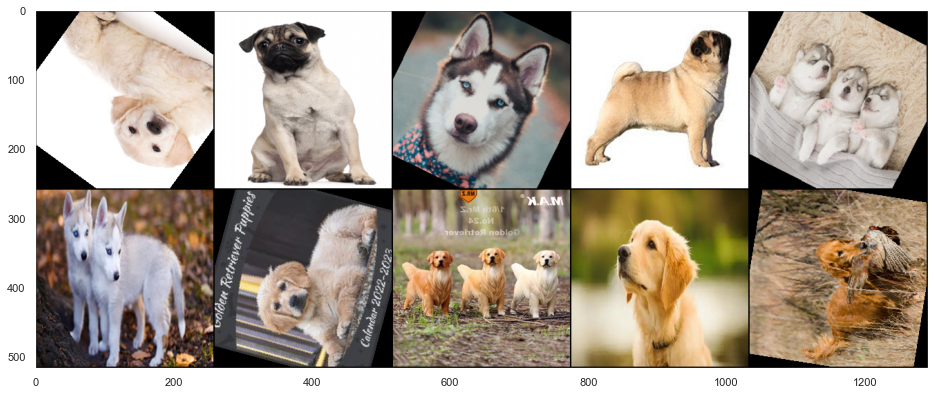

In [4]:
for images,labels in train_loader: 
    break

print('Label:', labels.numpy())
print('Class:', *np.array([classes[i] for i in labels]))

img = make_grid(images, nrow=5)

plt.figure(figsize=(16,10))
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)));
plt.grid()

In [5]:
class MLP(nn.Module):
    def __init__(self, in_sz=256*256*3, out_sz=3, layers=[256,128]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [6]:
#torch.manual_seed(123)
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

MLP(
  (fc1): Linear(in_features=196608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)

In [7]:
begin = time.time()

epochs = 5
train_batch_size = train_loader.batch_size
test_batch_size = test_loader.batch_size
train_data_size = len(train_data)
test_data_size = len(test_data)

train_losses = []
test_losses = []
train_corrects = []
test_corrects = []

for i in (range(epochs)):
    train_correct = 0
    test_correct = 0
    total_train = 0
    total_test = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        total_train += X_train.size()[0]
        y_pred = model(X_train.view(X_train.size()[0], -1))
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct += batch_correct
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if b%40 == 0 and b!=0:
            print("Epoch :{0}\t{1}/{2}\tLoss : {3:.4f}\tAccuracy : % {4:.2f} "\
                  .format(i,b*train_batch_size,train_data_size,loss.item(),train_correct.item()*100/total_train))
    
    train_losses.append(loss)
    train_corrects.append(train_correct)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            total_test += X_test.size()[0]
            y_val = model(X_test.view(X_test.size()[0], -1))
            
            predicted = torch.max(y_val.data, 1)[1] 
            test_correct += (predicted == y_test).sum()
            if b%X_test.size()[0]==0 and b!=0:
                print("Validation Accuracy : % {0:.2f}".format(test_correct.item()*100/total_test))
                print("-------------------------------------------------------------------")
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_corrects.append(test_correct)

print("Elapsed Time: {0:.0f} seconds".format((time.time()-begin)))

Epoch :0	400/1989	Loss : 6.3429	Accuracy : % 37.07 
Epoch :0	800/1989	Loss : 0.8658	Accuracy : % 40.86 
Epoch :0	1200/1989	Loss : 1.6770	Accuracy : % 40.83 
Epoch :0	1600/1989	Loss : 1.6963	Accuracy : % 42.42 
Validation Accuracy : % 60.91
-------------------------------------------------------------------
Epoch :1	400/1989	Loss : 1.5498	Accuracy : % 58.29 
Epoch :1	800/1989	Loss : 1.2797	Accuracy : % 52.59 
Epoch :1	1200/1989	Loss : 1.3837	Accuracy : % 52.89 
Epoch :1	1600/1989	Loss : 0.5563	Accuracy : % 53.79 
Validation Accuracy : % 62.73
-------------------------------------------------------------------
Epoch :2	400/1989	Loss : 1.2373	Accuracy : % 60.00 
Epoch :2	800/1989	Loss : 0.6177	Accuracy : % 60.12 
Epoch :2	1200/1989	Loss : 0.8879	Accuracy : % 59.34 
Epoch :2	1600/1989	Loss : 0.5965	Accuracy : % 59.01 
Validation Accuracy : % 50.91
-------------------------------------------------------------------
Epoch :3	400/1989	Loss : 0.8752	Accuracy : % 60.49 
Epoch :3	800/1989	Loss :

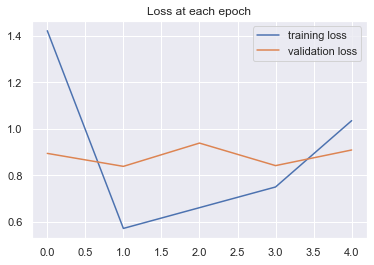

In [8]:
plt.plot([i.item() for i in train_losses], label='training loss')
plt.plot([i.item() for i in test_losses], label='validation loss')
plt.title('Loss at each epoch')
plt.legend();

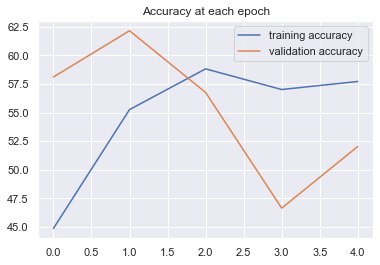

In [9]:
plt.plot([i.item()/len(train_data)*100 for i in train_corrects], label='training accuracy')
plt.plot([i.item()/len(test_data)*100 for i in test_corrects], label='validation accuracy')
plt.title('Accuracy at each epoch')
plt.legend();

In [10]:
def deneme(path):
    img = Image.open(path)
    if np.array(img).shape[2] ==4:
        img =  Image.fromarray(np.array(img)[:,:,:3])
    X_test = test_transform(img.resize((256,256))).to(device)
    with torch.no_grad():
          
        y_val = model(X_test[None,:].view(1, -1))
        predicted = torch.max(y_val.data, 1)[1] 
    return train_data.classes[predicted.item()]

In [11]:
deneme(r"C:\Users\omer-\Desktop\husky.png")

'husky'

In [12]:
deneme(r"C:\Users\omer-\Desktop\pug.png")

'husky'

In [13]:
deneme(r"C:\Users\omer-\Desktop\pug2.png")

'husky'

In [14]:
deneme(r"C:\Users\omer-\Desktop\golden.jpg")

'golden'